### Imports and activation functions

In [3]:
import jax
import jax.numpy as jnp
import numpy as np
import jax.numpy as jnp
import jax.random as random
import matplotlib.pyplot as plt
import pandas as pd
from functools import partial
import scipy.sparse as sp
import scipy.sparse.linalg as splinalg
from tqdm import tqdm
import time
import scipy

### Display helper functions

In [4]:
# Helper function to display large matrices in a nicer way.
def display_matrix(M, num_columns=None):
    df = pd.DataFrame(M)
    if num_columns is None or num_columns > len(df.columns):
        num_columns = len(df.columns)
    print(df.iloc[:, :num_columns])


# Example use:
M = jnp.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
display_matrix(M, num_columns=3)
display_matrix(M, num_columns=2)

print("-------------------")


# Helper function to display window intervals
def display_windows(xmins, xmaxs):
    data = {
        "Window #": [f"Window {i+1}" for i in range(len(xmins))],
        "xmins": xmins,
        "xmaxs": xmaxs,
    }
    df = pd.DataFrame(data)
    print(df)


# Example use:
xmins = jnp.array([0, 2, 4])
xmaxs = jnp.array([1, 3, 5])
display_windows(xmins, xmaxs)

   0  1  2
0  1  2  3
1  4  5  6
2  7  8  9
   0  1
0  1  2
1  4  5
2  7  8
-------------------
   Window #  xmins  xmaxs
0  Window 1      0      1
1  Window 2      2      3
2  Window 3      4      5


### Init Interval

In [5]:
def initInterval(J, xmin, xmax, width=1.9, verbose=False):
    sd = (xmax - xmin) / J
    xc = jnp.linspace(xmin, xmax, J)
    xmins = xc - width * sd
    xmaxs = xc + width * sd
    if verbose:
        display_windows(xmins, xmaxs)
    return xmins, xmaxs


# Example use:
# J = 5
# xmin = 0
# xmax = 1
# width = 1.9
# xmins, xmaxs = initInterval(J, xmin, xmax, width, verbose=True)


### Basis Functions

In [6]:
@partial(jax.jit, static_argnums=(1,))
def phi(x, activation, weight, bias, mu, sd):
    # x = norm(mu,sd,x)
    x = activation(jnp.dot(x, weight) + bias)
    # x = unnorm(mu,sd,x)
    return x

@partial(jax.jit, static_argnums=(1,))
def phi_dx(x, activation_dx, weight, bias, mu, sd):
    # x = norm(mu,sd,x)
    x = jnp.dot(activation_dx(jnp.dot(x, weight) + bias), weight)
    # x = unnorm(mu,sd,x)
    return x


@partial(jax.jit, static_argnums=(1,))
def phi_dxx(x, activation_dxx, weight, bias, mu, sd):
    # x = norm(mu,sd,x)
    x = jnp.dot(activation_dxx(jnp.dot(x, weight) + bias), jnp.square(weight))
    # x = unnorm(mu,sd,x)
    return x

### Window Functions

In [7]:
def window_hat(x, xmin, xmax):
    condition = jnp.logical_and(x >= xmin, x <= xmax)
    mu = (xmin + xmax) / 2.0
    sd = (xmax - xmin) / 2.0
    return jnp.where(condition, (1 + jnp.cos(jnp.pi * (x - mu) / sd)) ** 2, 0)

def window_hat_dx(x, xmin, xmax):
    condition = jnp.logical_and(x >= xmin, x <= xmax)
    mu = (xmin + xmax) / 2.0
    sd = (xmax - xmin) / 2.0
    return jnp.where(
        condition,
        -2
        * jnp.pi
        * (1 + jnp.cos(jnp.pi * (x - mu) / sd))
        * jnp.sin(jnp.pi * (x - mu) / sd)
        / sd,
        0,
    )

def window_hat_dxx(x, xmin, xmax):
    condition = jnp.logical_and(x >= xmin, x <= xmax)
    mu = (xmin + xmax) / 2.0
    sd = (xmax - xmin) / 2.0
    pi_term = jnp.pi * (x - mu) / sd

    term1 = 2 * jnp.pi**2 * jnp.sin(pi_term) ** 2 / sd**2
    term2 = 2 * jnp.pi**2 * jnp.cos(pi_term) * (1 + jnp.cos(pi_term)) / sd**2

    result = term1 - term2
    return jnp.where(condition, result, 0)


### Partition of Unity Functions

In [8]:
def POU(x, j, xmins, xmaxs, J):
    w_k = jnp.array([window_hat(x, xmins[k], xmaxs[k]) for k in range(J)])
    w_j = window_hat(x, xmins[j], xmaxs[j])

    return w_j / jnp.sum(w_k)


def POU_dx(x, j, xmins, xmaxs, J):
    w_k = jnp.array([window_hat(x, xmins[k], xmaxs[k]) for k in range(J)])
    w_j = window_hat(x, xmins[j], xmaxs[j])

    dwdx = jnp.array([window_hat_dx(x, xmins[k], xmaxs[k]) for k in range(J)])
    dwjdx = window_hat_dx(x, xmins[j], xmaxs[j])

    return (dwjdx * jnp.sum(w_k) - w_j * jnp.sum(dwdx)) / jnp.sum(w_k) ** 2


def POU_dxx(x, j, xmins, xmaxs, J):
    w_k = jnp.array([window_hat(x, xmins[k], xmaxs[k]) for k in range(J)])
    w_j = window_hat(x, xmins[j], xmaxs[j])

    dwdx = jnp.array([window_hat_dx(x, xmins[k], xmaxs[k]) for k in range(J)])
    dwjdx = window_hat_dx(x, xmins[j], xmaxs[j])

    dwdxx = jnp.array([window_hat_dxx(x, xmins[k], xmaxs[k]) for k in range(J)])
    dwjdxx = window_hat_dxx(x, xmins[j], xmaxs[j])

    sum_wk = jnp.sum(w_k)
    sum_dwdx = jnp.sum(dwdx)

    return (
        dwjdxx * sum_wk**2
        - 2 * dwjdx * sum_wk * sum_dwdx
        + 2 * w_j * sum_dwdx**2
        - w_j * jnp.sum(dwdxx) * sum_wk
    ) / sum_wk**3

### Loss Functions

In [9]:
# L1 Loss - Absolute Error
def calc_l1_loss(u, f_x):  # u - predicted, f_x - true
    loss = jnp.mean(jnp.abs(f_x - u)).item()
    print(f"Loss Value: {loss:.2e}")
    return loss


# Normalized L1 Loss - Absolute Error
def calc_normalized_l1_loss(
    a, M, b
):  # a - output weights, M - large solution matrix, b - RHS
    residual = M @ a - b
    l1_loss = jnp.mean(jnp.abs(residual))
    b_std = b.std()
    normalized_l1_loss = l1_loss / b_std
    print(f"Normalized L1 Loss Value: {normalized_l1_loss:.2e}")

    return normalized_l1_loss

### Functions for solving linear system

In [10]:
def least_squares_solver(M_csc, B, lmda, f, g):

    # M_csc = sp.csc_matrix(M)
    B_csc = sp.csc_matrix(B)

    LHS = M_csc.T @ M_csc + lmda * B_csc.T @ B_csc
    RHS = M_csc.T @ f + lmda * B_csc.T @ g

    start_time = time.time()
    a = splinalg.spsolve(LHS, RHS)
    end_time = time.time()

    elapsed_time = end_time - start_time

    lhs_condition_number = np.linalg.cond(LHS.toarray())

    print(f"Time taken for solver: {elapsed_time:.4f} seconds")
    return a, elapsed_time, lhs_condition_number

### Window plotting functions

In [11]:
def plot_window_hat(J, xmin_global, xmax_global, width, num_points=100):
    x = jnp.linspace(xmin_global, xmax_global, num_points)
    xmins, xmaxs = initInterval(J, xmin_global, xmax_global, width)

    plt.figure(figsize=(8, 6))
    for j in range(J):
        y = [window_hat(x[i], xmins[j], xmaxs[j]) for i in range(num_points)]
        plt.plot(x, y, label=f"Window {j+1} [{xmins[j]:.2f}, {xmaxs[j]:.2f}]")

    plt.title("Plot of window_hat function")
    plt.xlabel("x")
    plt.ylabel("window_hat(x)")
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_window_hat_dx(J, xmin_global, xmax_global, sd=None, num_points=100):
    x = jnp.linspace(xmin_global, xmax_global, num_points)
    xmins, xmaxs = initInterval(J, xmin_global, xmax_global, sd=sd)

    plt.figure(figsize=(8, 6))
    for j in range(J):
        y = [window_hat_dx(x[i], xmins[j], xmaxs[j]) for i in range(num_points)]
        plt.plot(x, y, label=f"Window {j+1} [{xmins[j]:.2f}, {xmaxs[j]:.2f}]")

    plt.title("Plot of window_hat function")
    plt.xlabel("x")
    plt.ylabel("window_hat(x)")
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_window_hat_dxx(J, xmin_global, xmax_global, sd=None, num_points=100):
    x = jnp.linspace(xmin_global, xmax_global, num_points)
    xmins, xmaxs = initInterval(J, xmin_global, xmax_global, sd=sd)

    plt.figure(figsize=(8, 6))
    for j in range(J):
        y = [window_hat_dxx(x[i], xmins[j], xmaxs[j]) for i in range(num_points)]
        plt.plot(x, y, label=f"Window {j+1} [{xmins[j]:.2f}, {xmaxs[j]:.2f}]")

    plt.title("Plot of window_hat function")
    plt.xlabel("x")
    plt.ylabel("window_hat(x)")
    plt.legend()
    plt.grid(True)
    plt.show()

### Partition of unity plotting functions

In [12]:
def plot_POU(J, global_xmin, global_xmax):
    x_plot = jnp.linspace(global_xmin, global_xmax, 100)
    colors = ["b", "g", "r", "c", "m"]

    xmins, xmaxs, sd = initInterval(J, global_xmin, global_xmax)

    plt.figure(figsize=(10, 6))

    omega_j = jnp.zeros_like(x_plot)
    for j in range(J):
        omega_j = [POU(x, j, xmins, xmaxs, J) for x in x_plot]
        plt.plot(x_plot, omega_j, label=f"Window {j}", color=colors[j])

    plt.title("Window Functions")
    plt.xlabel("x")
    plt.ylabel("Window Function Value")
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_POU_dx(J, global_xmin, global_xmax):

    x_plot = jnp.linspace(global_xmin, global_xmax, 100)
    colors = ["b", "g", "r", "c", "m"]
    xmins, xmaxs, sd = initInterval(J, global_xmin, global_xmax)
    plt.figure(figsize=(10, 6))

    omega_j = jnp.zeros_like(x_plot)
    for j in range(J):
        omega_j = [POU_dx(x, j, xmins, xmaxs, J) for x in x_plot]
        plt.plot(x_plot, omega_j, label=f"Window {j}", color=colors[j])

    plt.title("Window Functions")
    plt.xlabel("x")
    plt.ylabel("Window Function Value")
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_POU_dxx(J, global_xmin, global_xmax):
    x_plot = jnp.linspace(global_xmin, global_xmax, 100)
    colors = ["b", "g", "r", "c", "m"]
    xmins, xmaxs, sd = initInterval(J, global_xmin, global_xmax)
    plt.figure(figsize=(10, 6))

    omega_j = jnp.zeros_like(x_plot)
    for j in range(J):
        omega_j = [POU_dxx(x, j, xmins, xmaxs, J) for x in x_plot]
        plt.plot(x_plot, omega_j, label=f"Window {j}", color=colors[j])

    plt.title("Window Functions")
    plt.xlabel("x")
    plt.ylabel("Window Function Value")
    plt.legend()
    plt.grid(True)
    plt.show()

### Function to plot solution

In [13]:
def plot_solution(x, u, f_solution, title):

    plt.figure(figsize=(10, 6))
    plt.plot(x, u, label="Solution u", marker="o")
    plt.plot(x, f_solution, label="Function f(x)", marker="x")
    plt.title(f"{title}")
    plt.xlabel("x")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.show()

### Compute_M_entry
 - compute_M_entry_vmap<br> Function used to evaluate entries in to the training matrix, M_ode.

In [14]:
def compute_M_entry_vmap(x, j, J, c, weights, biases, xmins, xmaxs, sigma):
    sigma, sigma_dx, sigma_dxx = sigma, jax.grad(sigma), jax.grad(jax.grad(sigma))
    if J == 1:
        partition_dxx = 0
        partition_dx = 0
        partition = 1
    else:
        # partition = POU(x, j, xmins, xmaxs, J)
        # partition_dx = POU_dx(x, j, xmins, xmaxs, J)
        # partition_dxx = POU_dxx(x, j, xmins, xmaxs, J)
        
        partition = window_hat(x, xmins[j], xmaxs[j])
        partition_dx = window_hat_dx(x, xmins[j], xmaxs[j])
        partition_dxx = window_hat_dxx(x, xmins[j], xmaxs[j])


    mu = (xmins[j] + xmaxs[j]) / 2.0
    sd = (xmaxs[j] - xmins[j]) / 2.0
    
    # phi_dx = jax.grad(phi)
    # phi_dxx = jax.grad(phi_dx)

    basis = phi(x, sigma, weights[c], biases[c], mu, sd)
    basis_dx = phi_dx(x, sigma_dx, weights[c], biases[c], mu, sd)
    basis_dxx = phi_dxx(x, sigma_dxx, weights[c], biases[c], mu, sd)

    u_tt = partition_dxx * basis + 2 * partition_dx * basis_dx + partition * basis_dxx
    u_t = partition_dx * basis + partition * basis_dx
    u = partition * basis

    m = 1
    d = 2
    mu_param = 2 * d
    omega_0 = 80
    k = omega_0**2

    entry = m * u_tt + mu_param * u_t + (k + 1) * u

    return entry

### Compute u and du value
- compute_u_value - <br> Matrix entry function used to evaluate coefficients of u(t) (partition * basis). Used to build the boundary condition matrix <br>

- compute_u_value_vmap <br> Does the same thing, but is designed to be vmapped (used to build large matrix, M_sol)

In [15]:
def compute_u_value(x, l, j, J, c, weights, biases, xmins, xmaxs, sigma):
    if J == 1:
        partition = 1
    else:
        partition_POU = POU(x[l], j, xmins, xmaxs, J)
        #print(f"partition POU shape: {partition_POU.shape}")
        partition = window_hat(x[l], xmins[j], xmaxs[j])
        #print(f"partition window shape: {partition.shape}")
        partition_dx = window_hat_dx(x[l], xmins[j], xmaxs[j])
        partition_dxx = window_hat_dxx(x[l], xmins[j], xmaxs[j])

    mu = (xmins[j] + xmaxs[j]) / 2.0

    sd = (xmaxs[j] - xmins[j]) / 2.0

    basis = phi(x[l], sigma, weights[c], biases[c], mu, sd)

    u = partition * basis

    return u


def compute_du_value(x, l, j, J, c, weights, biases, xmins, xmaxs, sigma):
    POU_derivative = jax.grad(POU)
    if J == 1:
        partition_dx = 0
        partition = 1
    else:
        # partition = POU(x[l], j, xmins, xmaxs, J)
        # partition_dx = POU_derivative(x[l], j, xmins, xmaxs, J)
        
        partition = window_hat(x[l], xmins[j], xmaxs[j])
        partition_dx = window_hat_dx(x[l], xmins[j], xmaxs[j])
        partition_dxx = window_hat_dxx(x[l], xmins[j], xmaxs[j])

    mu = (xmins[j] + xmaxs[j]) / 2.0

    sd = (xmaxs[j] - xmins[j]) / 2.0
    
    #sigma_dx = jax.grad(sigma)
    phi_derivative = jax.grad(phi)

    basis = phi(x[l], sigma, weights[c], biases[c], mu, sd)
    basis_dx = phi_derivative(x[l], sigma, weights[c], biases[c], mu, sd)

    u_t = partition_dx * basis + partition * basis_dx
    return u_t

In [16]:
def compute_u_value_vmap(x, j, J, c, weights, biases, xmins, xmaxs, sigma):
    sigma, sigma_dx, sigma_dxx = sigma, jax.grad(sigma), jax.grad(jax.grad(sigma))
    if J == 1:
        partition = 1
    else:
        # partition = POU(x, j, xmins, xmaxs, J)
        partition = window_hat(x, xmins[j], xmaxs[j])
        partition_dx = window_hat_dx(x, xmins[j], xmaxs[j])
        partition_dxx = window_hat_dxx(x, xmins[j], xmaxs[j])

    mu = (xmins[j] + xmaxs[j]) / 2.0

    sd = (xmaxs[j] - xmins[j]) / 2.0

    basis = phi(x, sigma, weights[c], biases[c], mu, sd)

    u = partition * basis

    return u


def compute_du_value_vmap(x, j, J, c, weights, biases, xmins, xmaxs, sigma):
    sigma, sigma_dx, sigma_dxx = sigma, jax.grad(sigma), jax.grad(jax.grad(sigma))
    POU_derivative = jax.grad(POU)
    if J == 1:
        partition_dx = 0
        partition = 1
    else:
        # partition = POU(x, j, xmins, xmaxs, J)
        # partition_dx = POU_derivative(x, j, xmins, xmaxs, J)
        partition = window_hat(x, xmins[j], xmaxs[j])
        partition_dx = window_hat_dx(x, xmins[j], xmaxs[j])
        partition_dxx = window_hat_dxx(x, xmins[j], xmaxs[j])

    mu = (xmins[j] + xmaxs[j]) / 2.0

    sd = (xmaxs[j] - xmins[j]) / 2.0

    basis = phi(x, sigma, weights[c], biases[c], mu, sd)
    phi_dx = jax.grad(phi)
    basis_dx = phi_dx(x, sigma, weights[c], biases[c], mu, sd)
    #print("Yes I changed")
    #basis_dx = phi_dx(x, sigma_dx, weights[c], biases[c], mu, sd)

    u_t = partition_dx * basis + partition * basis_dx

    return u_t

### Sparse matrix building functions
- generate indices <br> Used to generate column and row indices for non-zero values <br>

- vectorized_matrix_entry <br> This function is vmapped to build out the large matrices. It takes a specific matrix entry function and will vmap over all the collocations, basis functions, and subdomains.

In [17]:
def generate_indices(C, xmins, xmaxs, x):
    """
    Generates row and column indices for a CSC (Compressed Sparse Column) matrix format. 
    This function determines which points in x fall within the subdomain ranges defined 
    by xmins and xmaxs, and assigns corresponding indices for matrix construction.

    The subdomains are indexed by j (ranging over J subdomains), and each subdomain 
    contains C basis functions, resulting in J * C columns in the matrix.

    Args:
        C (int): Number of basis functions per subdomain.
        xmins (jnp.ndarray): Minimum x values defining the subdomain ranges (shape: (J,)).
        xmaxs (jnp.ndarray): Maximum x values defining the subdomain ranges (shape: (J,)).
        x (jnp.ndarray): Input x values to be checked against subdomains (shape: (n,)).

    Returns:
        tuple: 
            - row_indices (jnp.ndarray): Row indices of the nonzero entries.
            - col_indices (jnp.ndarray): Column indices of the nonzero entries.
    """
    # Expand x, xmins, and xmaxs to perform the full batch condition check
    x_expanded = jnp.expand_dims(x, 1)  # (n, 1), for broadcasting
    xmins_expanded = jnp.expand_dims(xmins, 0)  # (1, J), for broadcasting
    xmaxs_expanded = jnp.expand_dims(xmaxs, 0)  # (1, J), for broadcasting

    # Condition check across the full batch
    inside = (x_expanded >= xmins_expanded) & (x_expanded <= xmaxs_expanded)  # (n, J) - True if x is within subdomain j
    inside = jnp.repeat(inside, C, axis=1)  # Repeat J times for each C to get (n, J * C)

    # Find indices where the condition is True
    row_indices, col_indices = jnp.nonzero(inside)

    return row_indices, col_indices



In [18]:
def vectorized_matrix_entry(rows, columns, x_batch, J, C, weights, biases, xmins, xmaxs, sigma, compute_entry_func):
    """
    Computes the values for a sparse matrix representation, given row and column indices.

    Each (row, col) index corresponds to an entry in the matrix where the basis function 
    σ(w_c * x + b_c) contributes. The function extracts the relevant subdomain (j) and 
    basis function index (c) from col, applies the activation function, and returns 
    the computed entry values for the matrix.

    Args:
        rows (jnp.ndarray): Row indices of the nonzero entries.
        columns (jnp.ndarray): Column indices of the nonzero entries.
        x_batch (jnp.ndarray): Input x values.
        J (int): Number of subdomains.
        C (int): Number of basis functions per subdomain.
        weights (jnp.ndarray): Weights of the basis functions.
        biases (jnp.ndarray): Biases of the basis functions.
        xmins (jnp.ndarray): Minimum x values defining the subdomain ranges.
        xmaxs (jnp.ndarray): Maximum x values defining the subdomain ranges.
        sigma (callable): Activation function.
        compute_entry_func (callable): Function to compute the matrix entry.

    Returns:
        jnp.ndarray: Computed values for the nonzero matrix entries.
    """
    def single_M_entry(idx):
        row = rows[idx]
        col = columns[idx]
        j = col // C  # Extract j from column index
        c = col % C   # Extract c from column index
        x = x_batch[row]

        entry_value = compute_entry_func(x, j, J, c, weights, biases, xmins, xmaxs, sigma)
        return entry_value

    values = jax.vmap(single_M_entry)(jnp.arange(rows.shape[0]))
    return values

### ELM-FBPINN Main Function
- Takes user defined variables and all functions above to build the training matrix, boundary matrix, evaluate a (output weight vector), and then builds a solution matrix, producing approximations of u(t) 

In [ ]:
def elmfbpinn(
    RHS_func, #RHS of ODE
    exact_solution_func, #exact solution function
    n_train, #number of training points
    n_test, #number of test points
    J, #number of subdomains
    C, #number of basis functions
    R, #sample range for weights
    xmin, #global xmin
    xmax, #global xmax
    width, #width of each subdomain
    sigma, #activation function
    lmda, #regularization parameter
    plot_window=False, #plot window function
    debug=False, #debug mode
):
    total_start_time = time.time()  # Start time for the entire function

    # Initialize weights and biases
    key = random.PRNGKey(0)
    w_key, b_key = random.split(key)
    weights = random.uniform(w_key, shape=(C,), minval=-R, maxval=R)  
    biases = random.uniform(b_key, shape=(C,), minval=-R, maxval=R)
    
    if debug:    
        print(f"weights: {weights}")
        print(f"biases: {biases}")

    # Initialize intervals for each subdomain
    xmins, xmaxs = initInterval(J, xmin, xmax, width=width, verbose=False)
    
    if debug:
        print(f"xmins: {xmins}")
        print(f"xmaxs: {xmaxs}")

    if plot_window:
        plot_window_hat(J, xmin, xmax, width)

    # Initialize training points
    x_train = jnp.linspace(xmin, xmax, n_train)

    # Generate indices for non-zero entries
    rows, columns = generate_indices(C, xmins, xmaxs, x_train)

    print("Creating M_ode...")
    start_time = time.time()

    # Compute the non-zero entries for the matrix
    M_values = vectorized_matrix_entry(rows, columns, x_train, J, C, weights, biases, xmins, xmaxs, sigma, compute_M_entry_vmap)

    # Scale the values
    M_values_scaled = M_values / jnp.max(jnp.abs(M_values))
    print(f"M_values scaled. Max value: {jnp.max(M_values_scaled)}")

    # Create the sparse matrix using row and column indices
    M_ode_sparse = scipy.sparse.csc_matrix((M_values_scaled, (rows, columns)), shape=(n_train, J * C))
    print(f"M_ode created in {time.time() - start_time:.2f} seconds.")

    # RHS values
    RHS_values = RHS_func(x_train) / jnp.max(jnp.abs(M_values))
    print("RHS values scaled.")

    # Initialize and compute B_train
    print("Creating B_train...")
    BC_train = jnp.zeros((2, J * C))

    # Single entry computation for B_train
    def single_B_train_entry(j, c):
        u_val = compute_u_value(
            x_train, 0, j, J, c, weights, biases, xmins, xmaxs, sigma
        )
        du_val = compute_du_value(
            x_train, 0, j, J, c, weights, biases, xmins, xmaxs, sigma
        )

        return u_val, du_val
    
    

    start_time = time.time()

    # Vectorize the single entry computation to build Boundary condition matrix values
    vmap_B_train_entry = jax.vmap(
        jax.vmap(single_B_train_entry, in_axes=(None, 0)), in_axes=(0, None)
    )
    
    # Compute Boundary matrix values
    u_vals, du_vals = vmap_B_train_entry(jnp.arange(J), jnp.arange(C))

    BC_train = BC_train.at[0].set(u_vals.reshape(J * C))
    BC_train = BC_train.at[1].set(du_vals.reshape(J * C))
    print(f"B_train created in {time.time() - start_time:.2f} seconds.")

    # Scaling B_train
    BC_scaling = jnp.diag(1.0 / jnp.max(jnp.abs(BC_train), axis=1))
    B_ode_scaled = BC_scaling @ BC_train
    print("B_train scaled.")

    # Boundary conditions
    g_train = jnp.zeros(2)
    g_train = BC_scaling @ g_train.at[0].set(1)

    
    start_time = time.time()

    # Solve the system with boundary conditions
    a, elapsed_time, lhs_condition = least_squares_solver(
        M_ode_sparse, B_ode_scaled, lmda, RHS_values, g_train
    )
    print(f"a calculated in {time.time() - start_time:.2f} seconds.")
    print(f"a shape: {a.shape}")
    print(f"First few values of a: {a[:5]}")

    # Initialize test points
    x_test = jnp.linspace(xmin, xmax, n_test)

    print("Creating M_sol...")
    start_time = time.time()
    
    # Generate indices for non-zero entries
    rows, columns = generate_indices(C, xmins, xmaxs, x_test)

    # Compute the non-zero entries for the matrix
    M_sol = vectorized_matrix_entry(rows, columns, x_test, J, C, weights, biases, xmins, xmaxs, sigma, compute_u_value_vmap)
    M_sol_sparse = scipy.sparse.csc_matrix((M_sol, (rows, columns)), shape=(x_test.shape[0], J * C))
    print(f"M_sol values created. Max value: {jnp.max(M_sol)}")
    print(f"M_sol created in {time.time() - start_time:.2f} seconds.")

    # Compute the solution
    u_test = M_sol_sparse @ a
    u_exact = exact_solution_func(x_test)

    # Plot the solution and print results.
    test_loss = calc_l1_loss(u_test, u_exact)
    print(f"Test Loss Value: {test_loss:.2e}")

    plot_solution(x_test, u_test, u_exact, f"Activation: {sigma.__name__}, J: {J}, C: {C}, R: {R}, Width: {width}, n_train: {n_train}, n_test: {n_test}")

    print(f"Condition number of M_ode_sparse: {jnp.linalg.cond(M_ode_sparse.toarray()):.2e}")
    print(f"Condition number of M_sol_sparse: {jnp.linalg.cond(M_sol_sparse.toarray()):.2e}")
    print(f"Condition Number of LHS: {lhs_condition:.2e}")

    loss = [test_loss]
    u = [u_test]
    Ms = [M_sol, M_ode_sparse, M_sol_sparse]
    B = [BC_train]
    f = [RHS_values]
    x = [x_test]

    total_elapsed_time = time.time() - total_start_time  # Total time taken
    print(f"Total time taken: {total_elapsed_time:.2f} seconds.")
        
    return Ms, B, a, u, loss, x, f, lhs_condition, xmins, xmaxs, total_elapsed_time, rows, columns





### Static ODE parameters and exact solution

In [20]:
# Damped Harmonic Oscillator parameters
m = 1
delta = 2
mu = 2 * delta
omega_0 = 80
k = omega_0**2
omega = jnp.sqrt(omega_0**2 - delta**2)


# Damped harmonic oscillator solution and its derivatives
def harm_u_exact(t):
    phi = jnp.arctan(-delta / omega)
    A = 1 / (2 * jnp.cos(phi))
    return 2 * A * jnp.exp(-delta * t) * jnp.cos(phi + omega_0 * t)


def zero_RHS(t):
    return 0.0 * harm_u_exact(t)

### Variables definition

In [21]:
RHS_func = zero_RHS
exact_solution_func = harm_u_exact
n_train = 150
n_test = 300
J = 20
C = 32
R = 25
xmin = 0.0
xmax = 1.0
width = 1.9
sigma = jnp.sin
activation = "sin"

### Executing ELM-FBPINN example

Creating M_ode...
M_values scaled. Max value: 0.9945811629295349
M_ode created in 0.13 seconds.
RHS values scaled.
Creating B_train...
B_train created in 0.20 seconds.
B_train scaled.
Time taken for solver: 0.0040 seconds
a calculated in 0.04 seconds.
Creating M_sol...
M_sol values created. Max value: 3.9999372959136963
M_sol created in 0.11 seconds.
Loss Value: 3.96e-03
Test Loss Value: 3.96e-03


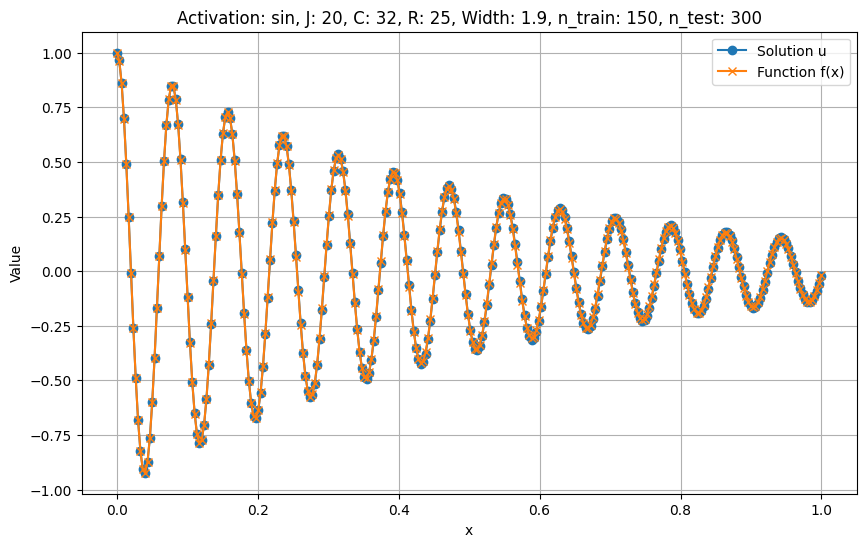

Condition number of M_ode_sparse: 1.28e+07
Condition number of M_sol_sparse: 2.56e+09
Condition Number of LHS: 3.09e+11
Total time taken: 0.71 seconds.


In [24]:
results = elmfbpinn(
    RHS_func, #RHS of ODE
    exact_solution_func, #exact solution function
    n_train, #number of training points
    n_test, #number of test points
    J, #number of subdomains
    C, #number of basis functions
    R, #sample range for weights
    xmin, #global xmin
    xmax, #global xmax
    width, #width of each subdomain
    sigma, #activation function
    lmda=1, #regularization parameter
    plot_window=False, #plot window function
    debug=False, #debug mode
)